### Importing Libraries

In [1]:
import sys
import os
import math
import time
import pandas as pd
from glob import iglob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix

### Importing dataset

In [2]:
benign=pd.read_csv("SecurityCam/benign_traffic.csv")
x_train, x_opt, x_test = np.split(benign.sample(frac=1, random_state=20), [int(1/3*len(benign)), int(2/3*len(benign))])

df_mirai = pd.concat((pd.read_csv(f) for f in iglob('SecurityCam/mirai/*.csv', recursive=False)), ignore_index=True)
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('SecurityCam/gafgyt/*.csv', recursive=False)), ignore_index=True)

In [3]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'malicious'

df_ben = x_train.copy()
df_ben['class'] = 'benign'

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=20))

### Plotting samples of benign and malicious data

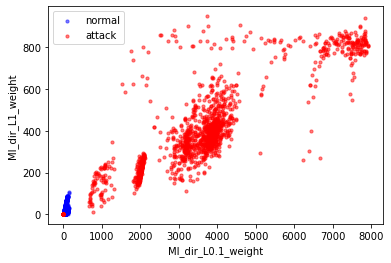

In [4]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()
plt.show()

In [5]:
classes = ['benign','malicious']
scored = []
indices = {}
shps = {}

#classifying benign as true and attack as false
for cl in classes:
    indices[cl] = df_ben['class'] == cl    
    shps[cl] =  df_ben[indices[cl]].shape[0]
        
for col in df_ben.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_ben[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_ben.shape[0]) * (m - df_ben[indices[cl]][col].mean())**2
        den += (shps[cl] / df_ben.shape[0]) * df_ben[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'HH_jit_L0.01_mean', 'score': 0.8188262695738087},
 {'feature': 'HH_jit_L0.1_mean', 'score': 0.8133162887063956},
 {'feature': 'HH_jit_L1_mean', 'score': 0.7769508654198414},
 {'feature': 'MI_dir_L0.1_weight', 'score': 0.7759777777720478},
 {'feature': 'H_L0.1_weight', 'score': 0.7759777777695762}]

### Predicting Anomaly

In [6]:
class AnomalyModel:
    #initialize model
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    #predict the outcome using treshold
    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)
    
    #scale the classes
    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)
        print(classes_arr)

        return np.array(classes_arr)

### Model creation - Deep autoencoder

In [7]:
def deep_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

### Fit model

In [8]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = deep_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",monitor='val_loss',save_best_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary())    

Epoch 1/100
1027/1027 [==============================] - 4s 3ms/step - loss: 0.2682 - val_loss: 0.0777
Epoch 2/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.0702 - val_loss: 0.0479
Epoch 3/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.0511 - val_loss: 0.0378
Epoch 4/100
1027/1027 [==============================] - 2s 1ms/step - loss: 0.0355 - val_loss: 0.0313
Epoch 5/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.0332 - val_loss: 0.0252
Epoch 6/100
1027/1027 [==============================] - 2s 1ms/step - loss: 0.0275 - val_loss: 0.0228
Epoch 7/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.0227 - val_loss: 0.0195
Epoch 8/100
1027/1027 [==============================] - 2s 1ms/step - loss: 0.0209 - val_loss: 0.0222
Epoch 9/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.0243 - val_loss: 0.0172
Epoch 10/100
1027/1027 [==============================] - 1s 1ms/step - l

### Predict train dataset

In [9]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

Selecting n------------------
For n 1
Accuracy
0.867820817345758
Precision 0.989980122510243
Recall 0.7431634082465436
Confusion Matrix [[32591   247]
 [ 8434 24404]]
For n 2
Accuracy
0.8697241001279006
Precision 0.9950256870260132
Recall 0.7431634082465436
Confusion Matrix [[32716   122]
 [ 8434 24404]]
For n 3
Accuracy
0.8702417930446434
Precision 0.9964475296039199
Recall 0.7431329557220293
Confusion Matrix [[32751    87]
 [ 8435 24403]]
For n 4
Accuracy
0.8704549607162434
Precision 0.9970174865174048
Recall 0.7431329557220293
Confusion Matrix [[32765    73]
 [ 8435 24403]]
For n 5
Accuracy
0.8706681283878434
Precision 0.9976287816843826
Recall 0.743102503197515
Confusion Matrix [[32780    58]
 [ 8436 24402]]
For n 6
Accuracy
0.8707594859613862
Precision 0.9978735585180338
Recall 0.743102503197515
Confusion Matrix [[32786    52]
 [ 8436 24402]]
For n 7
Accuracy
0.8708203910104148
Precision 0.9980368098159509
Recall 0.743102503197515
Confusion Matrix [[32790    48]
 [ 8436 24402]]
Fo

### Test data

In [10]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
deep_tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
deep_acc = accuracy_score(Y_test, Y_pred)
deep_precision = precision_score(Y_test, Y_pred)
deep_recall = recall_score(Y_test, Y_pred)
deep_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',deep_acc)
print('Precision ',deep_precision)
print("Recall",deep_recall)
print('Confusion Matrix',deep_cm)
   
#print(accs)

Test-----------------
best n 29
Threshold  2.913537642248193
Accuracy  0.8700286253730434
Precision  0.9993835278645405
Recall 0.740514038613801
Confusion Matrix [[32823    15]
 [ 8521 24317]]


### Variational Autoencoder

In [11]:
def vae_model(input_dim):
    original_dim = input_dim
    intermediate_dim = 64
    latent_dim = 2

    inputs = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    from keras import backend as K

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling)([z_mean, z_log_sigma])

    # Create encoder
    encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

    # Create decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    return Model(inputs, outputs, name='vae_mlp')


In [12]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = vae_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_vae.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.7306 - val_loss: 0.5760
Epoch 2/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6018 - val_loss: 0.5733
Epoch 3/100
1027/1027 [==============================] - 2s 1ms/step - loss: 0.5705 - val_loss: 0.5718
Epoch 4/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5825 - val_loss: 0.5699
Epoch 5/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.5664 - val_loss: 0.5672
Epoch 6/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5740 - val_loss: 0.5647
Epoch 7/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5775 - val_loss: 0.5628
Epoch 8/100
1027/1027 [==============================] - 2s 1ms/step - loss: 0.5708 - val_loss: 0.5622
Epoch 9/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.5736 - val_loss: 0.5623
Epoch 10/100
1027/1027 [==============================] - 2s 2ms/step - l

### Train

In [13]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9941835678177721
Precision 0.9885597302504817
Recall 0.9999390949509714
Confusion Matrix [[32458   380]
 [    2 32836]]
For n 2
Accuracy
0.9981271697423716
Precision 0.9963887961642339
Recall 0.9998781899019429
Confusion Matrix [[32719   119]
 [    4 32834]]
For n 3
Accuracy
0.9984316949875145
Precision 0.9969938966993593
Recall 0.9998781899019429
Confusion Matrix [[32739    99]
 [    4 32834]]
For n 4
Accuracy
0.9985382788233145
Precision 0.9972360588020897
Recall 0.9998477373774286
Confusion Matrix [[32747    91]
 [    5 32833]]
For n 5
Accuracy
0.9986144101346002
Precision 0.9974177476683781
Recall 0.9998172848529143
Confusion Matrix [[32753    85]
 [    6 32832]]
For n 6
Accuracy
0.9987818990194287
Precision 0.9977511699993922
Recall 0.9998172848529143
Confusion Matrix [[32764    74]
 [    6 32832]]
For n 7
Accuracy
0.9988428040684573
Precision 0.9978724697586773
Recall 0.9998172848529143
Confusion Matrix [[32768    70]
 [    6 32832

### Test

In [14]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
vae_acc = accuracy_score(Y_test, Y_pred)
vae_precision = precision_score(Y_test, Y_pred)
vae_recall = recall_score(Y_test, Y_pred)
vae_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',vae_acc)
print('Precision ',vae_precision)
print("Recall",vae_recall)
print('Confusion Matrix',vae_cm)

Test-----------------
best n 12
Treshold  21.827029617649078
Accuracy  0.9987362202326573
Precision  0.9979022892408719
Recall 0.9995736646568001
Confusion Matrix [[32769    69]
 [   14 32824]]


### Undercomplete Autoencoder

In [15]:
def uc_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(15, activation='relu')(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [16]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = uc_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_undercomplete.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1027/1027 [==============================] - 2s 1ms/step - loss: 0.7468 - val_loss: 0.5578
Epoch 2/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5566 - val_loss: 0.5459
Epoch 3/100
1027/1027 [==============================] - 2s 1ms/step - loss: 0.5351 - val_loss: 0.5427
Epoch 4/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5374 - val_loss: 0.5409
Epoch 5/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5335 - val_loss: 0.5400
Epoch 6/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5369 - val_loss: 0.5389
Epoch 7/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5339 - val_loss: 0.5382
Epoch 8/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5414 - val_loss: 0.5379
Epoch 9/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5571 - val_loss: 0.5376
Epoch 10/100
1027/1027 [==============================] - 1s 1ms/step - l

In [17]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))
        

Selecting n------------------
For n 1
Accuracy
0.9917016870698581
Precision 0.983732286767129
Recall 0.9999390949509714
Confusion Matrix [[32295   543]
 [    2 32836]]
For n 2
Accuracy
0.998157622266886
Precision 0.9964492731631817
Recall 0.9998781899019429
Confusion Matrix [[32721   117]
 [    4 32834]]
For n 3
Accuracy
0.9984773737742859
Precision 0.9970847251746128
Recall 0.9998781899019429
Confusion Matrix [[32742    96]
 [    4 32834]]
For n 4
Accuracy
0.9985535050855716
Precision 0.9972663487531513
Recall 0.9998477373774286
Confusion Matrix [[32748    90]
 [    5 32833]]
For n 5
Accuracy
0.9986600889213716
Precision 0.9975086589293309
Recall 0.9998172848529143
Confusion Matrix [[32756    82]
 [    6 32832]]
For n 6
Accuracy
0.9988275778062001
Precision 0.9978421420539161
Recall 0.9998172848529143
Confusion Matrix [[32767    71]
 [    6 32832]]
For n 7
Accuracy
0.9988428040684573
Precision 0.9978724697586773
Recall 0.9998172848529143
Confusion Matrix [[32768    70]
 [    6 32832]]

In [18]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
uc_acc = accuracy_score(Y_test, Y_pred)
uc_precision = precision_score(Y_test, Y_pred)
uc_recall = recall_score(Y_test, Y_pred)
uc_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',uc_acc)
print('Precision ',uc_precision)
print("Recall",uc_recall)
print('Confusion Matrix',uc_cm)

Test-----------------
best n 12
Treshold  21.383059035779077
Accuracy  0.9987362202326573
Precision  0.9979022892408719
Recall 0.9995736646568001
Confusion Matrix [[32769    69]
 [   14 32824]]


### Sparse Autoencoder

In [19]:
def sparse_model(input_dim):
    input_img = Input(shape=(input_dim,))
    encoded = Dense(200, activation='relu',
                activity_regularizer=regularizers.l1(10e-6))(input_img)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [20]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
    
#call function to create the model
model = sparse_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(X_train, X_train,
                    epochs=epochs, validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1027/1027 [==============================] - 3s 2ms/step - loss: 0.6099 - val_loss: 0.5390
Epoch 2/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.5433 - val_loss: 0.5368
Epoch 3/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5360 - val_loss: 0.5358
Epoch 4/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.5542 - val_loss: 0.5352
Epoch 5/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5215 - val_loss: 0.5350
Epoch 6/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.5249 - val_loss: 0.5348
Epoch 7/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5429 - val_loss: 0.5346
Epoch 8/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.5436 - val_loss: 0.5344
Epoch 9/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.5509 - val_loss: 0.5343
Epoch 10/100
1027/1027 [==============================] - 1s 1ms/step - l

In [21]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.9915951032340581
Precision 0.9835260288743785
Recall 0.9999390949509714
Confusion Matrix [[32288   550]
 [    2 32836]]
For n 2
Accuracy
0.998157622266886
Precision 0.9964492731631817
Recall 0.9998781899019429
Confusion Matrix [[32721   117]
 [    4 32834]]
For n 3
Accuracy
0.9984773737742859
Precision 0.9970847251746128
Recall 0.9998781899019429
Confusion Matrix [[32742    96]
 [    4 32834]]
For n 4
Accuracy
0.9985839576100859
Precision 0.9973269341757541
Recall 0.9998477373774286
Confusion Matrix [[32750    88]
 [    5 32833]]
For n 5
Accuracy
0.9986600889213716
Precision 0.9975086589293309
Recall 0.9998172848529143
Confusion Matrix [[32756    82]
 [    6 32832]]
For n 6
Accuracy
0.9988275778062001
Precision 0.9978421420539161
Recall 0.9998172848529143
Confusion Matrix [[32767    71]
 [    6 32832]]
For n 7
Accuracy
0.9988428040684573
Precision 0.9978724697586773
Recall 0.9998172848529143
Confusion Matrix [[32768    70]
 [    6 32832]

In [22]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
sparse_acc = accuracy_score(Y_test, Y_pred)
sparse_precision = precision_score(Y_test, Y_pred)
sparse_recall = recall_score(Y_test, Y_pred)
sparse_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',sparse_acc)
print('Precision ',sparse_precision)
print("Recall",sparse_recall)
print('Confusion Matrix',sparse_cm)

Test-----------------
best n 12
Treshold  21.347145231367207
Accuracy  0.9987362202326573
Precision  0.9979022892408719
Recall 0.9995736646568001
Confusion Matrix [[32769    69]
 [   14 32824]]


### Denoising Autoencoder

In [23]:
def denoise_model(input_dim):
    input_size = input_dim
    hidden_size = 44
    code_size = 5

    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)

    autoencoder = Model(input_img, output_img)
    return autoencoder

In [24]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]]
X_train = x_train[fs]
X_opt = x_opt[fs]
X_test = x_test[fs]
    
#standardize train and optimize data
scaler = StandardScaler()

noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_opt_noisy = np.clip(x_opt_noisy, 0., 1.)

X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)
#x_train_noisy = scaler.fit_transform(x_train_noisy)
#x_opt_noisy = scaler.transform(x_opt_noisy)

#call function to create the model
model = denoise_model(top_n_features)
model.compile(loss="mean_squared_error", optimizer="adam")
cp = ModelCheckpoint(filepath=f"anomaly/anomaly_sparse.h5",monitor='val_loss',
                     save_best_only=True,save_weights_only=True,verbose=0)

#Early Stopping function until val_loss is same for 5 epochs
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100
    
#fit on train dataset
history = model.fit(x_train_noisy, X_train,
                    epochs=epochs, validation_data=(x_opt_noisy, X_opt),
                    verbose=1, callbacks=[cp, es])
    
end = time.time()
print('time:', end - start)
print(model.summary()) 

Epoch 1/100
1027/1027 [==============================] - 2s 2ms/step - loss: 0.8382 - val_loss: 0.6866
Epoch 2/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6849 - val_loss: 0.6401
Epoch 3/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6399 - val_loss: 0.6352
Epoch 4/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6339 - val_loss: 0.6259
Epoch 5/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6380 - val_loss: 0.6235
Epoch 6/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6201 - val_loss: 0.6184
Epoch 7/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6359 - val_loss: 0.6156
Epoch 8/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6202 - val_loss: 0.6159
Epoch 9/100
1027/1027 [==============================] - 1s 1ms/step - loss: 0.6143 - val_loss: 0.6144
Epoch 10/100
1027/1027 [==============================] - 1s 1ms/step - l

In [25]:
#use optimization dataset to predict and find mse for anomaly detection
x_opt_predictions = model.predict(x_opt_noisy)
mse = np.mean(np.power(x_opt_noisy - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()
    
#sampling a benign dataset and adding a class malicious with 0
df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
    
#sampling a malicious dataset and adding a class malicious with 1
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
    
#combining benign and malicous dataset
df_combo = df_benign.append(df_malicious)
    
#X_opt with feature values
X_opt = df_combo.drop(columns=['malicious']).values
x_opt_noisy = X_opt + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_opt.shape) 
X_opt_scaled = scaler.transform(x_opt_noisy)

#Y_opt with target values
Y_opt = df_combo['malicious']
best_acc = 0
best_n = 0
#varying treshold and selecting the best model
print('Selecting n------------------')
for n in range(1,30):
    tr = mean + n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print(f'For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc  #determining the best aaccuracy
        best_n = n
    print(acc)
    print('Precision',precision_score(Y_opt, Y_pred))
    print("Recall",recall_score(Y_opt, Y_pred))
    print('Confusion Matrix',confusion_matrix(Y_opt, Y_pred))

Selecting n------------------
For n 1
Accuracy
0.6331232109141848
Precision 0.5767832364358105
Recall 1.0
Confusion Matrix [[ 8743 24095]
 [    0 32838]]
For n 2
Accuracy
0.7478987758085145
Precision 0.6648041299726692
Recall 1.0
Confusion Matrix [[16281 16557]
 [    0 32838]]
For n 3
Accuracy
0.8336074060539619
Precision 0.7503198976327575
Recall 0.9999695474754857
Confusion Matrix [[21911 10927]
 [    1 32837]]
For n 4
Accuracy
0.8925787197758694
Precision 0.8231681331628689
Recall 0.9999695474754857
Confusion Matrix [[25784  7054]
 [    1 32837]]
For n 5
Accuracy
0.9302789451245508
Precision 0.877642656688494
Recall 0.9999695474754857
Confusion Matrix [[28260  4578]
 [    1 32837]]
For n 6
Accuracy
0.9549607162433765
Precision 0.9173883891154943
Recall 0.9999695474754857
Confusion Matrix [[29881  2957]
 [    1 32837]]
For n 7
Accuracy
0.9694408916499178
Precision 0.9424274603220159
Recall 0.9999695474754857
Confusion Matrix [[30832  2006]
 [    1 32837]]
For n 8
Accuracy
0.977815335

In [26]:
#Creating a test Data frame and training model with test data
df_benign = pd.DataFrame(x_test_noisy, columns=fs)
df_benign['malicious'] = 0
df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=20)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 
X_test_scaled = scaler.transform(x_test_noisy)
Y_test = df2['malicious']
    
#using best n value for treshold determined using opotimization dataset
tr = mean + best_n * std
m = AnomalyModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print(f'best n {best_n}')
print("Threshold ",tr)
denoise_acc = accuracy_score(Y_test, Y_pred)
denoise_precision = precision_score(Y_test, Y_pred)
denoise_recall = recall_score(Y_test, Y_pred)
denoise_cm = confusion_matrix(Y_test, Y_pred)
print('Accuracy ',denoise_acc)
print('Precision ',denoise_precision)
print("Recall",denoise_recall)
print('Confusion Matrix',denoise_cm)

Test-----------------
best n 29
Treshold  7.13378303198655
Accuracy  0.9999238686887143
Precision  1.0
Recall 0.9998477373774286
Confusion Matrix [[32838     0]
 [    5 32833]]


### Deep Neural Net

In [27]:
def dnn_model(inputs):
    model = Sequential()
    model.add(Dense(115, input_dim=inputs, activation='relu'))
    model.add(Dense(80, input_dim=inputs, activation='relu'))
    model.add(Dense(10, input_dim=inputs, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(labels.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    es = EarlyStopping(monitor='val_loss', min_delta=1e-3, callbacks=[monitor], patience=5) 
    model.fit(x_train_st,y_train_st,validation_data=(x_test_st,y_test_st),
          verbose=1,epochs=100, callbacks=[es])

In [28]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 1

df_ben = x_train.copy()
df_ben['class'] = 0

df_ben = df_ben.append(df_attack.sample(n=df_ben.shape[0], random_state=17))

X = df_ben.drop(columns=['class'])
y = df_ben['class']

In [29]:
#split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=17)

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [30]:
#create model
model = Sequential()
model.add(Dense(115, input_dim=115, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
start = time.time()  #time function to determine time taken by model
epochs = 100

#compile and fit model
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train,y_train,epochs=epochs,batch_size=15,callbacks=[es])

end = time.time()
print("time",end-start)

Epoch 1/100
3503/3503 [==============================] - 5s 966us/step - loss: 0.0052
Epoch 2/100
3503/3503 [==============================] - 3s 884us/step - loss: 0.0013
Epoch 3/100
3503/3503 [==============================] - 3s 982us/step - loss: 0.0011
Epoch 4/100
3503/3503 [==============================] - 3s 819us/step - loss: 8.2216e-04
Epoch 5/100
3503/3503 [==============================] - 3s 767us/step - loss: 7.0724e-04
Epoch 6/100
3503/3503 [==============================] - 3s 789us/step - loss: 0.0011
Epoch 7/100
3503/3503 [==============================] - 3s 769us/step - loss: 9.1269e-04
Epoch 8/100
3503/3503 [==============================] - 3s 763us/step - loss: 8.8811e-04
Epoch 9/100
3503/3503 [==============================] - 3s 806us/step - loss: 6.8285e-04
time 27.796162843704224


In [31]:
predictions = model.predict(X_test)
y_pred = [round(x[0]) for x in predictions]

In [32]:
dnn_acc = accuracy_score(y_test, y_pred)
dnn_precision = precision_score(y_test, y_pred)
dnn_recall = recall_score(y_test, y_pred)
dnn_cm = confusion_matrix(y_test, y_pred)
print('Accuracy ',dnn_acc)
print('Precision ',dnn_precision)
print("Recall",dnn_recall)
print('Confusion Matrix',dnn_cm)

Accuracy  0.9986297198538368
Precision  0.998180991359709
Recall 0.999089667728721
Confusion Matrix [[6533   12]
 [   6 6585]]


### Model comparison

In [33]:
print("Provision PT_838_Security Camera")
model_summary = pd.DataFrame({'Model' :['Deep AutoEncoder',"Variational AutoEncoder","Sparse AutoEncoder","Undercomplete Autoencoder","Denoising Autoendoer"],
                             'Accuracy':[deep_acc,vae_acc,sparse_acc,uc_acc,denoise_acc],
                             'Precision':[deep_precision,vae_precision,sparse_precision,uc_precision,denoise_precision],
                             'Recall':[deep_recall,vae_recall,sparse_recall,uc_recall,denoise_recall],
                             'CM':[deep_cm,vae_cm,sparse_cm,uc_cm, denoise_cm]})
model_summary.sort_values(by='Accuracy', ascending=True)

Provision PT_838_Security Camera


,Model,Accuracy,Precision,Recall,CM
0,Deep AutoEncoder,0.870029,0.999384,0.740514,"[[32823, 15], [8521, 24317]]"
1,Variational AutoEncoder,0.998736,0.997902,0.999574,"[[32769, 69], [14, 32824]]"
2,Sparse AutoEncoder,0.998736,0.997902,0.999574,"[[32769, 69], [14, 32824]]"
3,Undercomplete Autoencoder,0.998736,0.997902,0.999574,"[[32769, 69], [14, 32824]]"
4,Denoising Autoendoer,0.999924,1.000000,0.999848,"[[32838, 0], [5, 32833]]"
